# IMaGES on ROI time series

In [1]:
import os
import pickle
from os.path import join as pjoin
import glob
import pandas as pd
import numpy as np
import pydot
from IPython.display import SVG
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import pyplot, patches
from pycausal import pycausal as pc
from pycausal import search as s
import networkx as nx
from networkx.drawing import nx_pydot
import itertools
import copy

In [2]:
%matplotlib inline

In [3]:
sb.set_context('notebook')

In [4]:
def getdfs(csvdir):
    """give us list of data frames for csv files in directory"""
    dfs = []
    for csvfile in glob.glob(csvdir + os.sep + "*.csv"):
        df = pd.read_csv(csvfile)
        dfs.append(df)
    return dfs

## Preprocessed BOLD data

In [5]:
# directory with csv files for roi time series (seperate csv file for each run)
csvdir_allruns = pjoin('/host', 'famfaces', 'extract_meants', 'csv', 'allruns')
dfs = getdfs(csvdir_allruns)

In [6]:
# perform images search
pc.start_vm() # start
images_raw = s.imagesSemBic(dfs, verbose = True)
pc.stop_vm() # stop

In [7]:
# show nodes
nodes = [str(node) for node in images_raw.getNodes()]

In [8]:
# show edges
# images.getEdges()

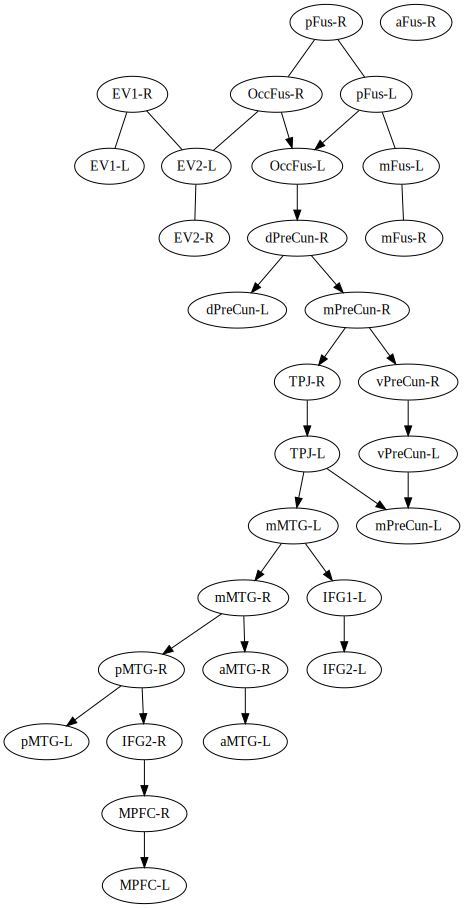

In [9]:
# render resulting graph
dot_raw = images_raw.getDot()
# dot_raw.write_png('graph_allruns_prep.png')
svg_str = dot_raw.create_svg(prog='dot')
SVG(svg_str)

## Residuals

From a nuisance model with motion parameters, outliers, and button press as regressors.

In [10]:
# nuisance data with button press
dfs_nb = getdfs(pjoin('/host', 'famfaces', 'extract_meants_nuisance_button', 'csv', 'run*'))

In [11]:
# perform images search
pc.start_vm() # start
images_nb = s.imagesSemBic(dfs_nb, verbose = True)
pc.stop_vm() # stop

In [12]:
# nodes and edges
# images_nb.getNodes()
# images_nb.getEdges()  

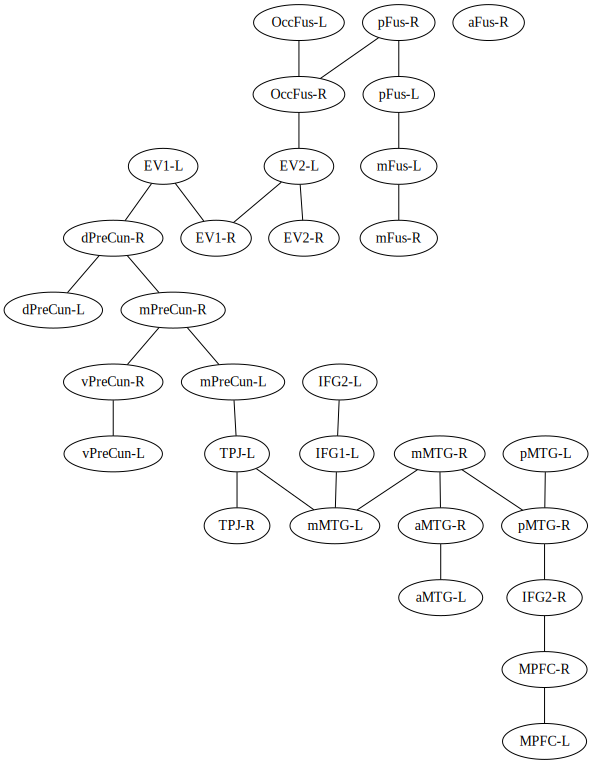

In [13]:
# render resulting graph
dot_nb = images_nb.getDot()
# dot_nb.write_png('graph_allruns_residuals.png')
SVG(dot_nb.create_svg(prog='dot'))

## Residual data without button press as regressor

In [14]:
dfs_n = getdfs(pjoin('/host', 'famfaces', 'extract_meants_nuisance', 'csv', 'run*'))

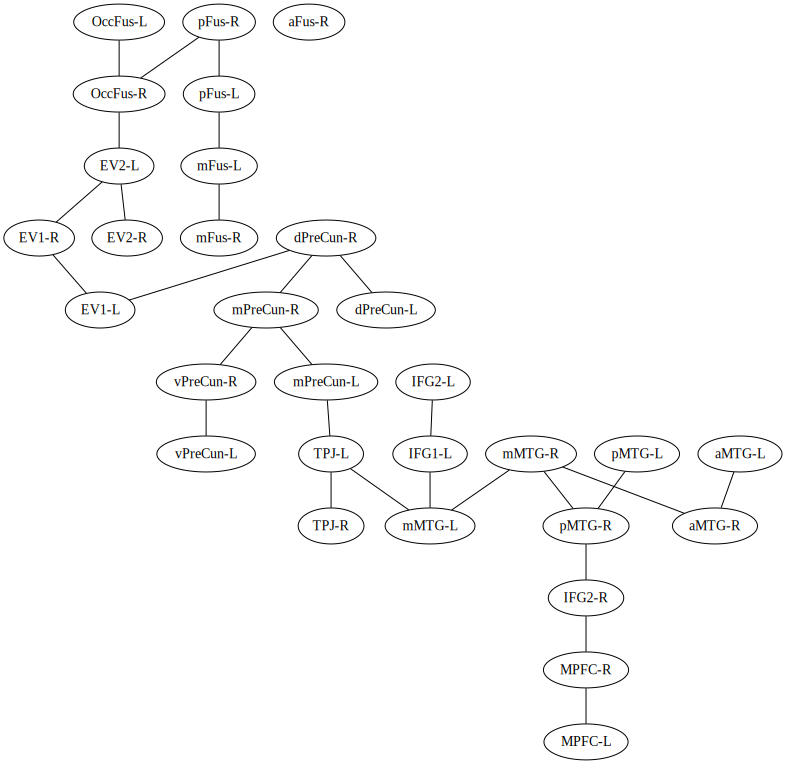

In [15]:
pc.start_vm()
images_n = s.imagesSemBic(dfs_n, verbose = True)
pc.stop_vm()

dot_n = images_n.getDot()
# dot_nb.write_png('graph_allruns_residuals.png')
SVG(dot_n.create_svg(prog='dot'))

### Conclusion: Preprocessed vs. residual data

Taking the residuals of a nuisance model as input for IMaGES results in no directed edges.

However, the generall look of the network makes sense. And since it is only plausible, that the signal has to start in early visual areas, you can see a nice progression from early visual areas to fusiform gyrus, but on the other hand from early visual to precuneus, to TJP, to IFG, to MTP, to MPFC.

**However**... it does look structurally different than the model based on the preprocessed data. So the question is, which one we should trust more. The residual one might be more conservative, because it (at least) should be less prone to artifact variance.

# Extract directed edges from images object *manually*

In [16]:
def splitpair(pair):
    """
    split string containing two nodes into a tuple of two nodes.
    ignore directedness of connection.
    Used in get_adjacencies.
    """
    split = tuple([label.replace('- ', '').replace('> ', '').replace(' ', '') # looks ugly, but is supposedly faster
                   for label in pair.split('--')])
    return split

In [17]:
def get_adjacencies(images_instance):
    """
    returns a list of tuples of connected nodes (i.e. pairs)
    """
    
    # get edges and convert from unicode to string
    images_edges = images_instance.edges
    edgestrings = [str(edge) for edge in images_edges]
    
    # split the strings to get tuples, turn into arrays and sort
    edges = np.array([splitpair(pair) for pair in edgestrings])
    connections = edges[np.argsort(edges[:, 0])]
    
    return connections

# get undirected adjacency matrices

In [18]:
# switch from images.pydot to nx graph
graph_raw = nx_pydot.from_pydot(dot_raw)
graph_nb = nx_pydot.from_pydot(dot_nb)

In [19]:
# make graph undirected
und_raw = graph_raw.to_undirected()
und_nb = graph_nb.to_undirected()

In [20]:
def get_sorted_matrix_nx(G):
    """
    Use nx inherent method to extract numpy matrix from given graph object.
    rows and columns will be sorted by node label alphabetically.
    """
    node_order = sorted(G.nodes())
    adjacency_matrix = nx.to_numpy_matrix(G, dtype=np.bool, nodelist=node_order)
    return adjacency_matrix

In [21]:
# adjacency matrix of the new undirected graph
am_und_raw = get_sorted_matrix_nx(und_raw)
am_und_nb = get_sorted_matrix_nx(und_nb)

# Graph Matching methods

**Simple matching**

return the fraction of identical elements between two arrays

In [22]:
def simple_match(m1, m2):
    """
    return the relative number of identical elements between two arrays.
    """
    assert np.shape(m1) == np.shape(m2)
    return float(np.sum(m1 == m2)) / float(m1.size)

In [23]:
# simple matching graphs from preprocessed and residual data
match_residuals_preprocessed = simple_match(am_und_raw, am_und_nb)
print(match_residuals_preprocessed)

0.986666666667


**Jaccard Index**

Use Scikit learn. Basically, the Jaccard index is the intersection divided by the union of two sets.

In [24]:
from sklearn.metrics import jaccard_similarity_score as jaccard

In [25]:
# jaccard index comparing graphs from preprocessed and residual data
jaccard(am_und_raw, am_und_nb)

0.86111111111111105

## Similarity across runs of undirected graphs (preprocessed data)

In [26]:
basedir = '/host/famfaces/extract_meants/csv'
rundirs_raw = [pjoin(basedir, 'run%03d' % i) for i in xrange(1,12)]

In [27]:
def csv2am_undirected(rundir):
    """
    Procedure to run images over all datasets in one run,
    convert to nx, make graph undirected, and extract
    sorted adjacency matrix.
    """
    # get dataframes
    dfs = getdfs(rundir)  
    # perform iamges
    pc.start_vm()
    images = s.imagesSemBic(dfs, verbose = True)
    pc.stop_vm()
    # convert images to nx via pydot
    G = nx_pydot.from_pydot(images.getDot()) 
    G_undir = G.to_undirected() # make graph undirected
    # get sorted adjacency matrix
    am = get_sorted_matrix_nx(G_undir)
    return am

In [28]:
def get_all_ams(rundirs):
    """
    get adjacency matrices of all runs
    """
    am_list = [csv2am_undirected(rundir) for rundir in rundirs]
    return am_list

In [29]:
## this command takes a while to execute
# am_list = get_all_ams(rundirs_raw)

In [30]:
# save am_list as pickle
#with open('am_list.pickle', 'wb') as handle:
#    pickle.dump(am_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('am_list.pickle', 'rb') as handle:
    am_list = pickle.load(handle)

In [31]:
def compare_runs(am_list, method='simple', symmetric=False):
    """
    pairwise comparison of matrices in a list of matrices.
    Choose between different measures of similarity.
    Choose if the input matrices are symmetric, due to undirected graphs.
    """
    
    if symmetric:
        am_list = [np.triu(am) for am in am_list]
    
    if method=='simple':
        match_list = np.array([
            [simple_match(am1, am2) for am1 in am_list]
            for am2 in am_list])
        
    if method=='jaccard':
        match_list = np.array([
            [jaccard(am1, am2) for am1 in am_list]
            for am2 in am_list])
        
    return match_list

In [32]:
def plot_match_matrix(match_matrix, ttl=None, axis=None):
    
    if axis:
        matrixplot = sb.heatmap(match_matrix, square=True, cmap='viridis', ax=axis)
    else:
        matrixplot = sb.heatmap(match_matrix, square=True, cmap='viridis')
    plt.xticks(np.arange(0.5, 11.5, 1), range(1,12))
    plt.yticks(np.arange(0.5, 11.5, 1), range(1,12))
    
    if ttl:
        plt.title(ttl, fontweight='bold')

    print('minimum: ' + str(np.min(match_matrix)))
    print('maximum: ' + str(np.max(match_matrix)))
    print('mean: ' + str(np.mean(match_matrix)))

    return matrixplot

In [33]:
# simple matching of undirected adjacency matrices for preprocessed data
match_matrix_raw = compare_runs(am_list, symmetric=True)

In [34]:
def plot_clustered(matrix, colormap='viridis', meth='average',
                   dendrogram=False, ttl=None, colorbar=True):
    """
    Plot clustered correlation matrix using seaborn's clustermap.
    """

    clustermap = sb.clustermap(matrix, cmap='viridis', method=meth, figsize=(7,7),
                               xticklabels=range(1,12),
                               yticklabels=range(1,12))
    if not dendrogram:
        clustermap.ax_row_dendrogram.set_visible(False)
        clustermap.ax_col_dendrogram.set_visible(False)
    if not colorbar:
        clustermap.cax.set_visible(False)
    if ttl:
        clustermap.ax_heatmap.set_title(ttl, fontweight='bold', loc='center', fontsize=14)

    return clustermap

In [35]:
# jaccard index of undirected adjacency matrices for preprocessed data
jaccard_matrix_raw = compare_runs(am_list, method='jaccard', symmetric=True)

### conclusion

Wether you use Jaccard or Simple Matching, the general pattern of correlation across runs stays the same. In a nutshell, the first 2-3 runs correlate less with the other runs than the other runs among each other. In other words, the graph topology seems to 'stabilize' after the second run.

**TODO:**

Find out which adjacencies change

## Similarity across runs of DIRECTED graphs (preprocessed data)

In [36]:
def get_mixed_adjacency_dicts(images_instance):
    """
    create a list of dicts, each containing the pair of nodes
    and wether edge is directed.
    """
    edgestrings = [str(edge) for edge in images_instance.edges]
    
    pairdicts = []
    for element in sorted(edgestrings):
        pairdict = {}
        if '-->' in element:
            pairdict['directed'] = True
            pair = element.split('-->')
        else:
            pairdict['directed'] = False
            pair = [word.replace('- ', '')
                    for word in element.split('--')]

        # remove whitespace and append
        pairdict['pair'] = [string.replace(' ', '') for string in pair]
        pairdicts.append(pairdict)
    return pairdicts

In [37]:
adjacency_dicts = get_mixed_adjacency_dicts(images_raw)
# show first few entries as example
adjacency_dicts[:5]

[{'directed': False, 'pair': ['EV1-R', 'EV1-L']},
 {'directed': False, 'pair': ['EV1-R', 'EV2-L']},
 {'directed': False, 'pair': ['EV2-L', 'EV2-R']},
 {'directed': True, 'pair': ['IFG1-L', 'IFG2-L']},
 {'directed': True, 'pair': ['IFG2-R', 'MPFC-R']}]

In [38]:
def mixed_am_from_images(images_instance):
    """
    Get adjacency matrix that allows undirected and directed edges
    from result of IMaGES by py-causal.
    """
    
    # get nodes and dict of adjacencies (mixed)
    adjacency_dicts = get_mixed_adjacency_dicts(images_instance)
    nodes = [str(node) for node in images_instance.nodes]

    # initiate empty matrix
    am = np.zeros((len(nodes),len(nodes)))
    
    for edgedict in adjacency_dicts:
        # find out node indices for source and target
        source_index = nodes.index(edgedict['pair'][0])
        target_index = nodes.index(edgedict['pair'][1])
        # fill in matrix
        am[source_index, target_index] = 1
        # for undirected edges, also fill in on other side of diagonal
        if not edgedict['directed']:
            am[target_index, source_index] = 1
    return am

In [39]:
def csv2mixed_am(rundir):
    """
    Use above to run IMaGES on csv directory and extract mixed adjacency matrix
    """
    # get dataframes
    dfs = getdfs(rundir)  
    # perform iamges
    pc.start_vm()
    images_instance = s.imagesSemBic(dfs, verbose = True)
    pc.stop_vm()
    # get mixed adjacency matrix
    am = mixed_am_from_images(images_instance)
    return am

In [40]:
# get mixed adjacency matrices for preprocessed data
mixed_ams = [csv2mixed_am(rundir) for rundir in rundirs_raw]
np.shape(mixed_ams)

(11, 30, 30)

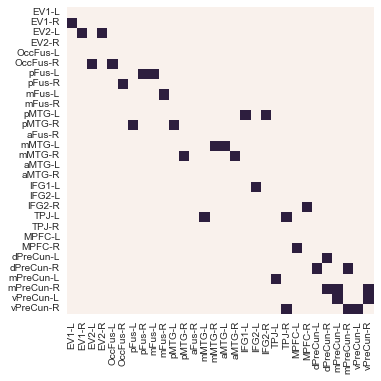

In [41]:
# inspect one random am
sb.heatmap(mixed_ams[1],
           cbar=False, square=True,
           xticklabels=nodes, yticklabels=nodes)

In [42]:
#with open('mixed_ams.pickle', 'wb') as handle:
#    pickle.dump(mixed_ams, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [43]:
# simple matching of directed adjacency matrices from preprocessed data
simple_matches_directed = compare_runs(mixed_ams)

In [44]:
# jaccard index of directed adjacency matrices from preprocessed data
jaccard_directed = compare_runs(mixed_ams, method='jaccard')

## Similarity across runs of undirected graphs (residual data)

In [45]:
basedir_nb = '/host/famfaces/extract_meants_nuisance_button/csv'
rundirs_nb = [pjoin(basedir_nb, 'run%02d' % i) for i in xrange(1,12)]

In [46]:
# again, this takes a while. use pickle
am_list_nb = get_all_ams(rundirs_nb)

In [47]:
# save am_list_nb as pickle
#with open('am_list_nb.pickle', 'wb') as handle:
#    pickle.dump(am_list_nb, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [48]:
# Graph similarity (simple matching) across runs for residual data
match_matrix_nb = compare_runs(am_list_nb, symmetric=True)

In [49]:
# graph similarity (jaccard index) for residual data
jaccard_matrix_nb = compare_runs(am_list_nb, method='jaccard', symmetric=True)

# Overview plot

In [103]:
def overview_plot(fonts=16, figs=(20,8), equal_limits=False):
    """
    Make an overview plot containing heatmaps in two rows, and four columns.
    Each heatmap represents graph similarity across runs.
    We plot seperate heatmaps for each similarity measure (jaccard vs. simple matching),
    data used (preprocessed vs. residual), and directionality of edges (undirected vs. directed).
    """
    # TODO: make this function more flexible
    
    fig, axs = plt.subplots(ncols=4, nrows=2, figsize=figs)
    
    # arguments for seaborn heatmap plot
    kwargs = {'xticklabels': range(1,12),
              'yticklabels': range(1,12),
              'cbar': True,
              'square': True,
              'cmap': 'viridis'}

    # set equal vmin and vmax to all color bars if desired 
    if equal_limits:
        kwargs['vmin'] = np.min([match_matrix_raw, jaccard_matrix_raw, simple_matches_directed,
                                 jaccard_directed, match_matrix_nb, jaccard_matrix_nb])
        kwargs['vmax'] = np.max([match_matrix_raw, jaccard_matrix_raw, simple_matches_directed,
                                 jaccard_directed, match_matrix_nb, jaccard_matrix_nb])
        
    # preprocessed data (left half of panel)

    positions_prep = [(0,0), (0,1), (1,0), (1,1)]
    matrices_prep = [match_matrix_raw, jaccard_matrix_raw, simple_matches_directed, jaccard_directed]
    titles_prep = ['simple matching\npreprocessed data', 'jaccard\npreprocessed data'] *2
        
    for mat, pos, ttl in zip(matrices_prep, positions_prep, titles_prep):
        heatmap = sb.heatmap(mat, ax=axs[pos], **kwargs)
        heatmap.set_title(ttl, fontweight='bold', fontsize=fonts)

    # residuals (right half of panel)

    positions_res = [(0,2), (0,3)]
    matrices_res = [match_matrix_nb, jaccard_matrix_nb]
    titles_res = ['simple matching\nresidual data', 'jaccard\nresidual data']

    for mat, pos, ttl in zip(matrices_res, positions_res, titles_res):
        heatmap = sb.heatmap(mat, ax=axs[pos], **kwargs)
        heatmap.set_title(ttl, fontweight='bold', fontsize=fonts)

    # turn off redundant axes
    axs[1,2].axis('off')
    axs[1,3].axis('off')
    
    # row labels
    rownames = ['undirected', 'directed']
    for ax, rowname in zip(axs[:,0], rownames):
        ax.set_ylabel(rowname, rotation=90, fontsize=fonts, fontweight='bold')
    
    return fig, axs

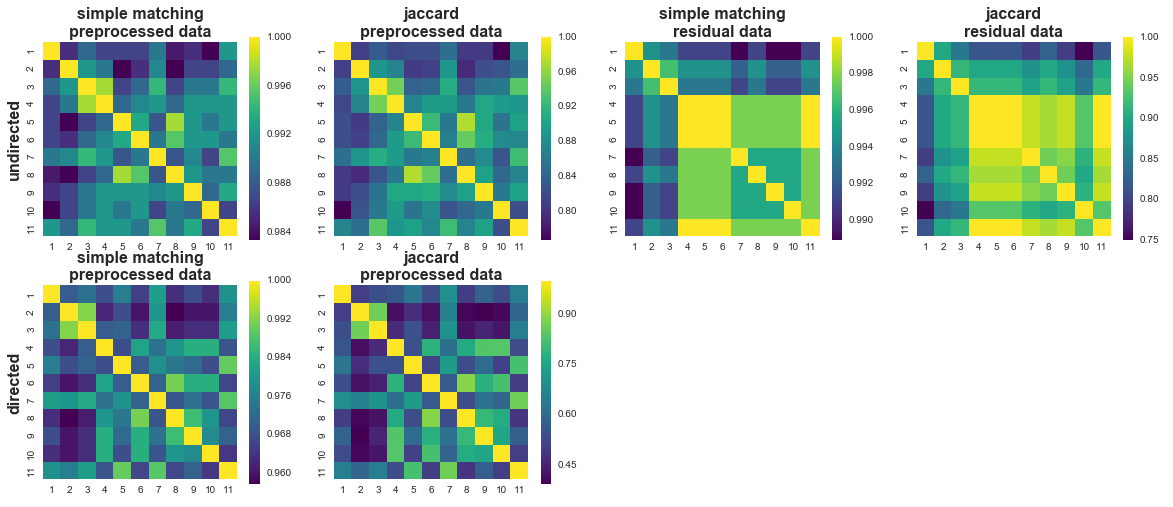

In [104]:
fig, axs = overview_plot()

In [52]:
# fig.savefig('overview_graphcomp_runs.png', dpi=300)

# Influence of experimental stimulation

We modelled the influence of familiarity as a kind of differential regressor. For that purpose, stimulus onsets for familiar and unfamiliar faces respectively were convolved with a canonical HRF, and the result subtracted (familiar - unfamiliar).

See also the notebook 'model_contrast_for_tetrad.ipynb' and the script 'meants_tetrad.py'

## Residual data

In [53]:
path_withc_nb = pjoin('/host', 'famfaces', 'extract_meants_nuisance_button_withcontrast', 'sub*', 'csv', 'run*')

In [54]:
dfs_withc_nb = getdfs(path_withc_nb)

In [55]:
# perform images search
pc.start_vm() # start
images_withc_nb = s.imagesSemBic(dfs_withc_nb, verbose = True)
pc.stop_vm() # stop

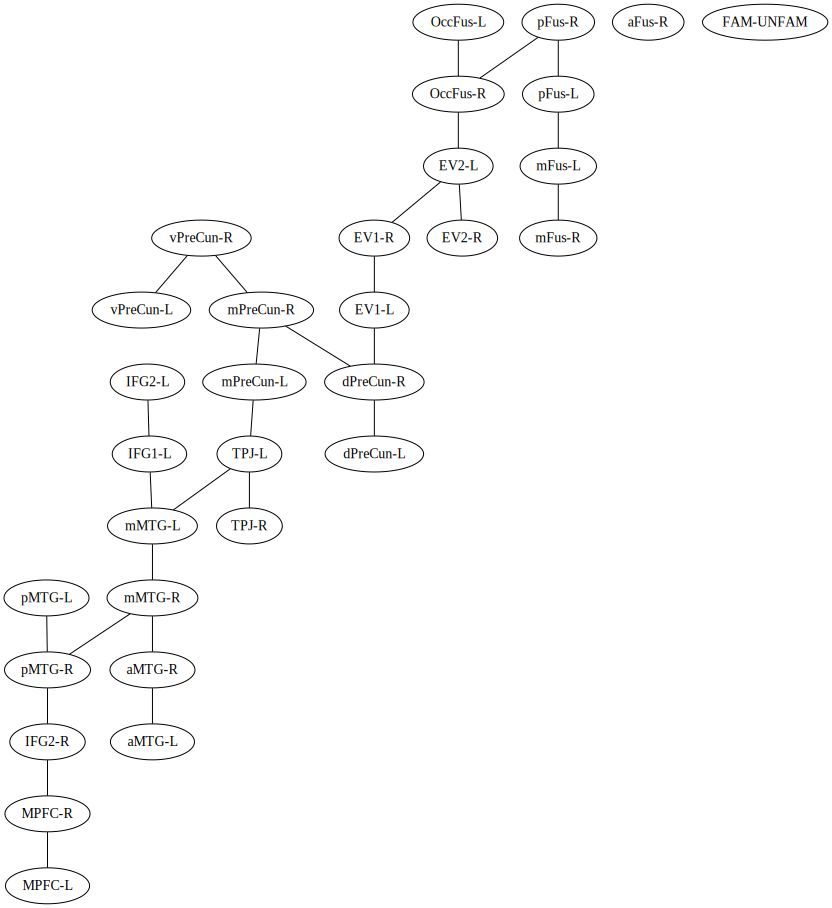

In [56]:
# render resulting graph
dot_withc_nb = images_withc_nb.getDot()
svg_str = dot_withc_nb.create_svg(prog='dot')
SVG(svg_str)

## Preprocessed data

In [57]:
path_withc_raw = pjoin('/host', 'famfaces', 'extract_meants_withcontrast', 'sub*', 'csv', 'run*')

In [58]:
dfs_withc_raw = getdfs(path_withc_raw)

In [59]:
# perform images search
pc.start_vm() # start
images_withc_raw = s.imagesSemBic(dfs_withc_raw, verbose = True)
pc.stop_vm() # stop

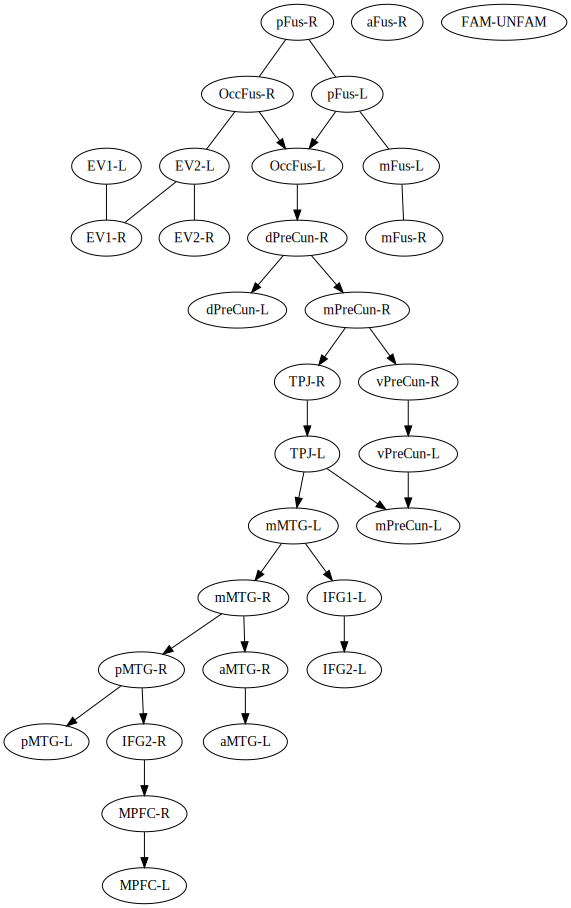

In [60]:
# render resulting graph
dot_withc_raw = images_withc_raw.getDot()
svg_str = dot_withc_raw.create_svg(prog='dot')
SVG(svg_str)

## Conclusion stimulus modelling

The constructed differential regressor (fam-unfam) does not fit in the graph, regardless of which data is used.

# AR modelling

Explore if AR modelling changes the failure to connect the familiarity effect to the rest of the network.

## Preprocessed data

In [61]:
from statsmodels.tsa.ar_model import AR

/Users/Oliver/anaconda2/envs/famface/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [62]:
def ar_df(in_df, tr=2, lag=1):
    """
    perform AR modelling on all columns in a given data frame.
    Keep in mind that resulting data frame will be missing first row.
    """
    # don't change original data frames, make copy instead
    df = copy.deepcopy(in_df)
    
    # give df a timestamp as index
    df['time'] = range(tr,len(df)*tr+1,tr)
    df.index = pd.to_datetime(pd.to_timedelta(df['time'],unit='s'))
    df = df.drop('time', 1)
    
    # get column names
    header = list(df.columns.values)
    
    for cond in header:
        # autoregressive model
        ar_mod = AR(df[cond].astype(float), dates=df.index)

        fit = ar_mod.fit(lag)
        results = fit.predict()
        df[cond] = results # change respective column in df

    df = df.iloc[lag:] # don't include rows that are NaN due to AR
    
    return df

In [63]:
# perform AR modelling for all data frames based on preprocessed data
dfs_withc_raw_ar = [ar_df(df) for df in dfs_withc_raw]

In [64]:
# perform images search
pc.start_vm() # start
images_withc_raw_ar = s.imagesSemBic(dfs_withc_raw_ar, verbose = True)
pc.stop_vm() # stop

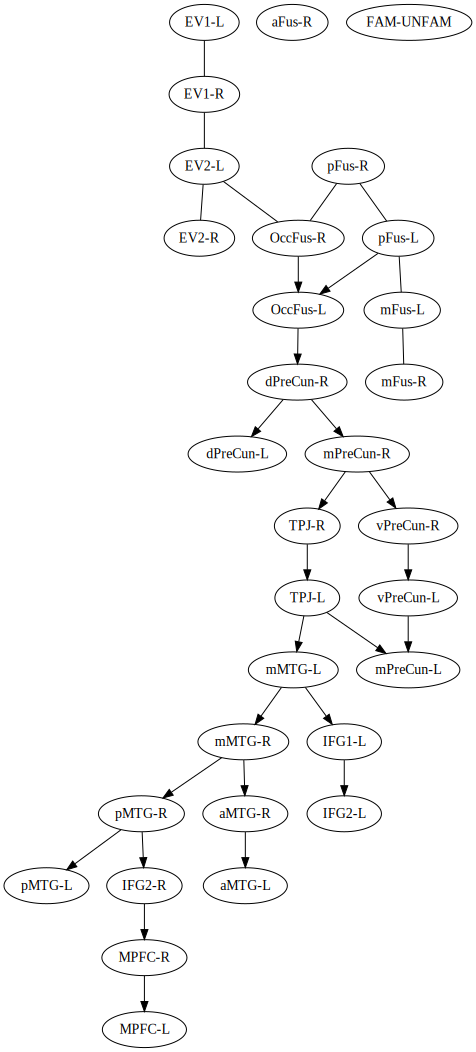

In [65]:
# render resulting graph
dot_withc_raw_ar = images_withc_raw_ar.getDot()
svg_str = dot_withc_raw_ar.create_svg(prog='dot')
SVG(svg_str)

In [66]:
sb.set_style('white')

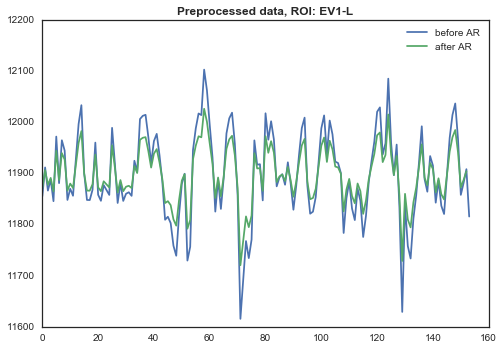

In [67]:
# time series of EV1-L before AR
plt.plot(dfs_withc_raw[0]['EV1-L'].values)
plt.plot(dfs_withc_raw_ar[0]['EV1-L'].values)
plt.legend(['before AR', 'after AR'])
plt.title('Preprocessed data, ROI: EV1-L', fontweight='bold')

## Residual data

In [68]:
# perform AR modelling for all data frames based on preprocessed data
dfs_withc_nb_ar = [ar_df(df) for df in dfs_withc_nb]

In [69]:
# perform images search
pc.start_vm() # start
images_withc_nb_ar = s.imagesSemBic(dfs_withc_nb_ar, verbose = True)
pc.stop_vm() # stop

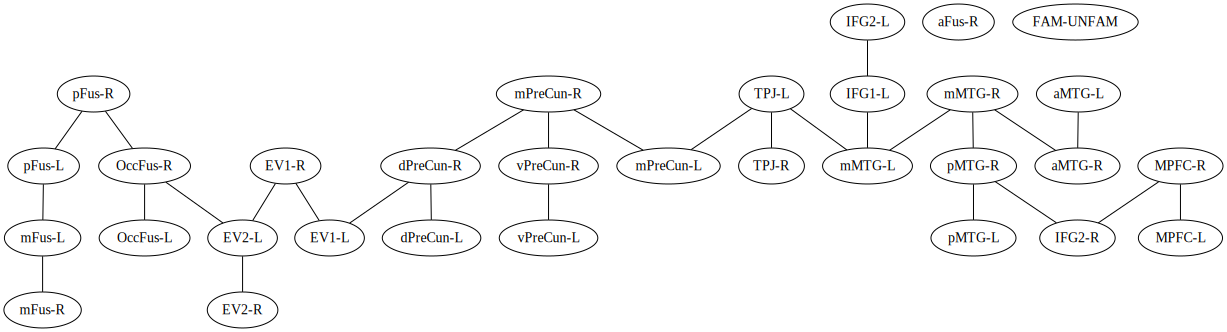

In [70]:
# render resulting graph
dot_withc_nb_ar = images_withc_nb_ar.getDot()
svg_str = dot_withc_nb_ar.create_svg(prog='dot')
SVG(svg_str)

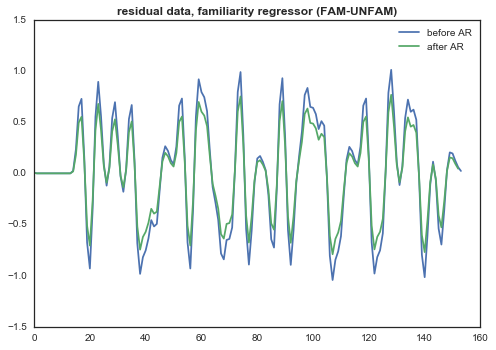

In [71]:
# example time series before AR in residual data
plt.plot(dfs_withc_nb[0]['FAM-UNFAM'].values)
plt.plot(dfs_withc_nb_ar[0]['FAM-UNFAM'].values)
plt.legend(['before AR', 'after AR'])
plt.title('residual data, familiarity regressor (FAM-UNFAM)', fontweight='bold')

## Conclusion AR modelling

AR modelling does not influence the graph (neither for preprocessed nor residual data).

# Which edges change?

Work in progress

## residual data

In [72]:
## reshape our list of adjacency matrices, so we can make a heatmap
## with 11 columns (for each run) and 900 rows (for each possible edge)

# np.shape(am_list_nb)
# am_list_nb_reshape = np.array(am_list_nb).reshape(900,11)
# np.shape(am_list_nb_reshape)

In [73]:
## plot heatmap

# fig, ax = plt.subplots(figsize=(18,30))
# hm = sb.heatmap(am_list_nb_reshape, cbar=False, xticklabels=False)